In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Dense-Video-Captioning

/content/drive/MyDrive/Dense-Video-Captioning


In [ ]:
!pip install

In [4]:
import numpy as np
import os, sys
import pickle, functools, operator
import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib
#import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import json
import random
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import datetime
from keras.layers import concatenate

In [ ]:
train_path='training_data'
TRAIN_LABEL_PATH = os.path.join(train_path, 'training_label.json')
# mentioning the train test split

open("/content/drive/MyDrive/Dense-Video-Captioning/data/training_data/training_label.json")
train_split = 0.85
# loading the json file for training
with open("/content/drive/MyDrive/Dense-Video-Captioning/data/training_data/training_label.json") as data_file:    
    y_data = json.load(data_file)
# train_list contains all the captions with their video ID
# vocab_list contains all the vocabulary from training data
train_list = []
vocab_list = []
for y in y_data:
  for caption in y['caption']:
    caption = "<bos> " + caption + " <eos>"
    # we are only using sentences whose length lie between 6 and 10
    if len(caption.split())>10 or len(caption.split())<6:
      continue
    else:
      train_list.append([caption, y['id']])
print(len(train_list))
random.shuffle(train_list)
training_list = train_list[:int(len(train_list)*train_split)]
validation_list = train_list[int(len(train_list)*train_split):]
for train in training_list:
    #print(train) #['<bos> The bird is dancing. <eos>', 'cJOZp2ZftCw_1_12.avi']
    vocab_list.append(train[0])
# Tokenizing the words
tokenizer = Tokenizer(num_words=1500)
tokenizer.fit_on_texts(vocab_list)
print(len(tokenizer.word_index))
x_data = {}
TRAIN_FEATURE_DIR = os.path.join('training_data', 'featEficientNet')
# Loading all the numpy arrays at once and saving them in a dictionary
for filename in os.listdir("/content/drive/MyDrive/Dense-Video-Captioning/data/training_data/featEficientNet"):
    f = np.load(os.path.join("/content/drive/MyDrive/Dense-Video-Captioning/data/training_data/featEficientNet", filename))
    x_data[filename[:-4]] = f
print(len(training_list))
print(len(validation_list))
len(x_data)

17216
3963
14633
2583


1450

In [ ]:
# Creating a custom data generator because we cannot load so many files at once
def load_datatest(train_path, epochs=100, x_data=x_data, tokenizer=tokenizer, num_decoder_tokens=1500,training_list=train_list, batch_size=160, maxlen=10):
    encoder_input_data = []
    decoder_input_data = []
    decoder_target_data = []
    videoId = []
    videoSeq = []
    # separating the videoId and the video captions
    for idx, cap in enumerate(training_list):
        caption = cap[0]
        videoId.append(cap[1])
        videoSeq.append(caption)
    # converting the captions to tokens and padding them to equal sizes
    train_sequences = tokenizer.texts_to_sequences(videoSeq)
    train_sequences = np.array(train_sequences)
    train_sequences = pad_sequences(train_sequences, padding='post',truncating='post', maxlen=maxlen)
    max_seq_length = train_sequences.shape[1]
    filesize = len(train_sequences)
    X_data = []
    y_data = []
    vCount = 0
    n = 0
    print("hi")
    for i in range(epochs):
      for idx in  range(0,filesize):
        n += 1
        videoId[idx]= videoId[idx].split(".")[0]
        encoder_input_data.append(x_data[videoId[idx]])
        y = to_categorical(train_sequences[idx], num_decoder_tokens)
        decoder_input_data.append(y[:-1])
        decoder_target_data.append(y[1:])
        if n == batch_size:
          encoder_input = np.array(encoder_input_data)
          decoder_input = np.array(decoder_input_data)
          decoder_target = np.array(decoder_target_data)
          encoder_input_data = []
          decoder_input_data = []
          decoder_target_data = []
          n = 0
          yield ([encoder_input, decoder_input], decoder_target)

In [ ]:
# writing the train and validation generator
train = load_datatest(train_path='training_data',batch_size=320, training_list=training_list, x_data=x_data, epochs=150)
valid = load_datatest(train_path='training_data',batch_size=320, training_list=validation_list, x_data=x_data, epochs=150)

In [ ]:
"""
time_steps_encoder is the number of frames per video we will be using for training
num_encoder_tokens is the number of features from each frame
latent_dim is the number of hidden features for lstm
time_steps_decoder is the maximum length of each sentence
num_decoder_tokens is the final number of tokens in the softmax layer
batch size
"""
time_steps_encoder=20
num_encoder_tokens=2560
latent_dim= 256
time_steps_decoder=10
num_decoder_tokens=1500
batch_size=100

In [ ]:
!pip install keras==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 20, 2560)]   0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 10, 1500)]   0           []                               
                                                                                                  
 encoder_lstm (LSTM)            [(None, 20, 256),    2884608     ['encoder_inputs[0][0]']         
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

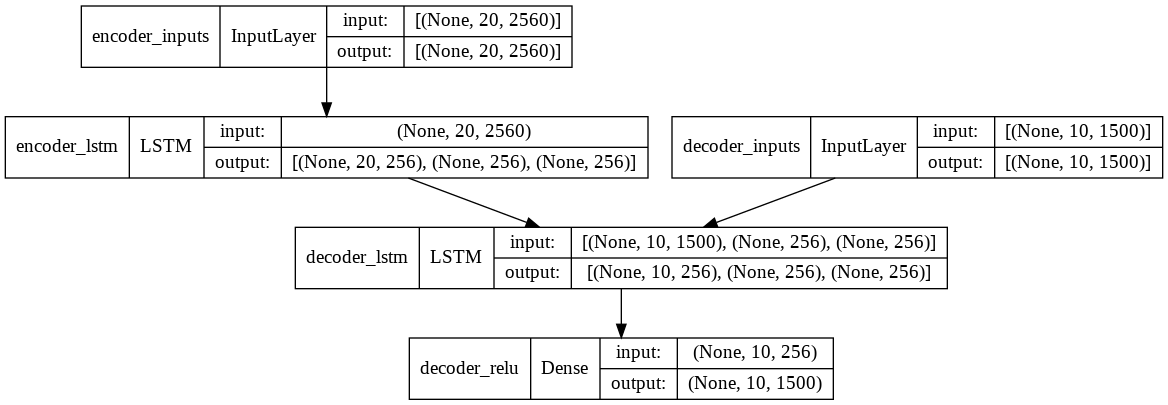

In [ ]:

# Setting up the encoder  ,merge_mode='concat'
encoder_inputs = Input(shape=(time_steps_encoder, num_encoder_tokens), name="encoder_inputs")
encoder = LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder_lstm')
_, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


# Set up the decoder
decoder_inputs = Input(shape=(time_steps_decoder, num_decoder_tokens), name= "decoder_inputs")
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm',dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_relu')
decoder_outputs = decoder_dense(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()
plot_model(model, to_file='model_train.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Early Stopping
earlystopping = EarlyStopping(monitor='val_loss', patience = 3, verbose=1, mode='min')

# Tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Run training
opt = tf.keras.optimizers.Adam(
    learning_rate=0.0001,clipvalue=0.5
)
x = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,patience=2,verbose=0,mode="auto")
model.compile(metrics=['accuracy'], optimizer=opt, loss='categorical_crossentropy')


try:
    model.fit(train, validation_data=valid, validation_steps=(len(validation_list)//batch_size),
        epochs=30, steps_per_epoch=(len(training_list)//batch_size),
            callbacks=[x, earlystopping, tensorboard_callback])
except KeyboardInterrupt:
    print("\nW: interrupt received, stopping")
finally:
    pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


hi
Epoch 1/30
146/146 [==============================] - 24s 113ms/step - loss: 4.8526 - accuracy: 0.2994 - val_loss: 3.5539 - val_accuracy: 0.3397 - lr: 1.0000e-04
Epoch 2/30
146/146 [==============================] - 16s 106ms/step - loss: 3.5279 - accuracy: 0.3660 - val_loss: 3.3691 - val_accuracy: 0.3911 - lr: 1.0000e-04
Epoch 3/30
146/146 [==============================] - 15s 105ms/step - loss: 3.3703 - accuracy: 0.3864 - val_loss: 3.2319 - val_accuracy: 0.3993 - lr: 1.0000e-04
Epoch 4/30
146/146 [==============================] - 15s 102ms/step - loss: 3.2387 - accuracy: 0.4066 - val_loss: 3.1150 - val_accuracy: 0.4320 - lr: 1.0000e-04
Epoch 5/30
146/146 [==============================] - 15s 102ms/step - loss: 3.1217 - accuracy: 0.4271 - val_loss: 3.0064 - val_accuracy: 0.4461 - lr: 1.0000e-04
Epoch 6/30
146/146 [==============================] - 15s 104ms/step - loss: 3.0113 - accuracy: 0.4443 - val_loss: 2.9103 - val_accuracy: 0.4578 - lr: 1.0000e-04
Epoch 7/30
146/146 [=====

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 20, 2560)]       0         
                                                                 
 encoder_lstm (LSTM)         [(None, 20, 256),         2884608   
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 2,884,608
Trainable params: 2,884,608
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_inputs (InputLayer)    [(None, 10, 1500)]   0           []                               

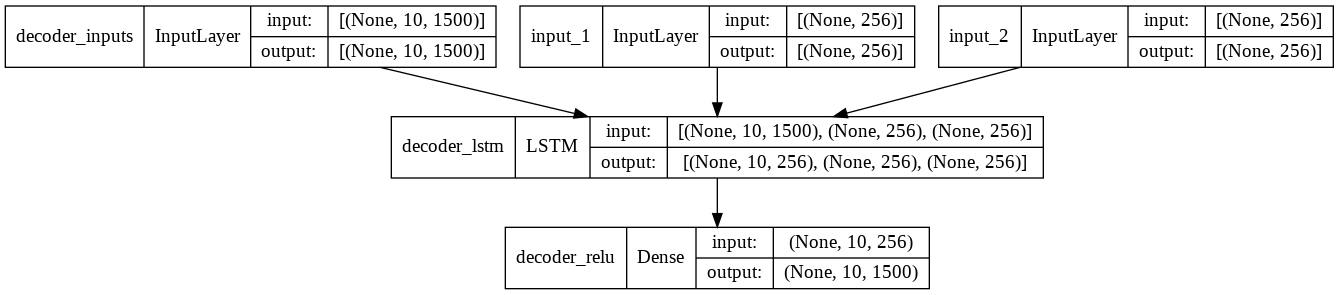

In [ ]:
save_model_path = '/content/drive/MyDrive/Dense-Video-Captioning/modelLSTM_LSTM'
if not os.path.exists(save_model_path):
    os.makedirs(save_model_path)

# Saving encoder as in training
encoder_model = Model(encoder_inputs, encoder_states)

# Saving decoder states and dense layer 
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)
encoder_model.summary()
decoder_model.summary()
encoder_model.save(os.path.join(save_model_path, 'encoder_model_LSTM_LSTM.h5'))
decoder_model.save_weights(os.path.join(save_model_path, 'decoder_model_weights_LSTM_LSTM.h5'))
with open(os.path.join(save_model_path,'tokenizer'+ str(num_decoder_tokens) ),'wb') as file:
    joblib.dump(tokenizer, file)
plot_model(encoder_model, to_file='model_inference_encoder.png', show_shapes=True, show_layer_names=True)
plot_model(decoder_model, to_file='model_inference_decoder.png', show_shapes=True, show_layer_names=True)